# oPool Analysis - Activity Scores

In [221]:
import pandas as pd
import json # export dictionaries
import datetime
import os
import sys
import glob # seqsearch
import subprocess # seqsearch
%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append('/ref/dblab/software/opool/code/src')
from figures import *
from stats import *
from sequence_parsing import *

pd.set_option('future.no_silent_downcasting', True)

### Select Data
For most up to date full run data:
- oPool1 submissions: 'oPool1-4_5-20-24_full-run_GTAC', '011625_oPool1b_GTAC'
- oPool2 submissions: 'oPool2-2_combined_full-run_GTAC', '013125_oPool2b_GTAC'
- oPool3 submissions: '122324_oPool3_10-2-24_GTAC', '031025_oPool3b_GTAC'
- oPool4 submissions: '052924_oPool4.5.17_full-run_GTAC', '012425_oPool4b_GTAC'
- oPool5 submissions: 'oPool5_08-09-24_full-run_GTAC', '030325_oPool5b_GTAC'

In [222]:
# Sequencing run information
opool_num = 5 # used to set reference sequences
submission = '030325_oPool5b_GTAC' # must match a case name in "oPool Specific Variables" below

In [223]:
# Require variants appear in the specified number of bins and replicates.
b = 3
r = 3

avg_method = 'rep-weighted' # options (simple-avg, rep-weighted, codon-weighted)

# Require a certain number of normalized reads in each bin for a variant to be scored
# opool1, rep1, bin1 reads = 137610197. 5/137610197*1000000 = 0.0363 reads per million
minread_threshold = 0 # reads per million

### Select Exports

In [224]:
# Output files
seq_search = False # counts truncated spike-in sequence. Change subseq variable to search for other motifs
export_df = True # save activity score dataframes to csv
export_stats = True # save activity score stats to json (needed for all_opools_heatmap.ipynb)

In [225]:
# set score column to be used for plots and stats
if avg_method == 'simple-avg':
    score_col = 'avgscore'
elif avg_method == 'rep-weighted':
    score_col = 'avgscore_rep_weighted'
elif avg_method == 'codon-weighted':
    score_col = 'avgscore_codon_weighted'

In [226]:
# Get the current date
current_date = datetime.datetime.now().strftime("%Y%m%d")
print(current_date)

export_suffix = f'{submission}_{b}-bins_{minread_threshold}-minreads_{current_date}'

20250408


### oPool Specific Variables
- read counts from the CGS email or GTAC sample map 
- Siteman bin values
- Path to files containing unique counts of amplicon sequences
- Filenames for unique counts files

In [227]:
match submission:
    case '031025_oPool3b_GTAC':
        #GFP median intensity of bins
        gfp_rep1_bin1 = 85.8
        gfp_rep1_bin2 = 161
        gfp_rep1_bin3 = 668
        gfp_rep1_bin4 = 2209
        gfp_rep2_bin1 = 78.2
        gfp_rep2_bin2 = 168
        gfp_rep2_bin3 = 606
        gfp_rep2_bin4 = 2065
        gfp_rep3_bin1 = 66.9
        gfp_rep3_bin2 = 154
        gfp_rep3_bin3 = 564
        gfp_rep3_bin4 = 1945

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 83280720
        read_count[1] = 83533659
        read_count[2] = 100515039
        read_count[3] = 94138863
        read_count[4] = 91324164
        read_count[5] = 106527578
        read_count[6] = 118442516
        read_count[7] =  145709935
        read_count[8] = 116914150
        read_count[9] = 100151830
        read_count[10] = 55018725
        read_count[11] = 112294050
        read_count[12] = 103102383
        read_count[13] = 108333381

        project_dir = '/scratch/dblab/opool/data/results/oPool3/031025_oPool3b_GTAC_allowlist-match'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']

    case '030325_oPool5b_GTAC':
        #GFP median intensity of bins
        gfp_rep1_bin1 = 125
        gfp_rep1_bin2 = 242
        gfp_rep1_bin3 = 953
        gfp_rep1_bin4 = 3077
        gfp_rep2_bin1 = 111
        gfp_rep2_bin2 = 226
        gfp_rep2_bin3 = 827
        gfp_rep2_bin4 = 3282
        gfp_rep3_bin1 = 86.9
        gfp_rep3_bin2 = 204
        gfp_rep3_bin3 = 711
        gfp_rep3_bin4 = 3038

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 93335051 + 38013168
        read_count[1] = 102606862 +45307832
        read_count[2] = 74357968 + 32724818
        read_count[3] = 75393971 + 33106487
        read_count[4] = 93094462 + 39259132
        read_count[5] = 64549755 + 30382114
        read_count[6] = 89303873 + 34775693
        read_count[7] = 100813592 + 43668775
        read_count[8] = 79373783 + 34415035
        read_count[9] = 93444866 + 37572151
        read_count[10] = 66659708 + 32502674
        read_count[11] = 86346094 + 36977168
        read_count[12] = 85468879 + 33582490
        read_count[13] = 76316244 + 33633147

        project_dir = '/scratch/dblab/opool/data/results/oPool5/030325_oPool5b_GTAC_allowlist-match'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']


    case '022425_oPool3b_CGS_spike-in':
        #GFP median intensity of bins
        gfp_bin1 = 1000
        gfp_bin2 = 1900
        gfp_bin3 = 2500
        gfp_bin4 = 6000

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 56514
        read_count[1] = 57981
        read_count[2] = 69392
        read_count[3] = 69026
        read_count[4] = 63285
        read_count[5] = 71675
        read_count[6] = 70049
        read_count[7] = 91059
        read_count[8] = 73246
        read_count[9] = 66245
        read_count[10] = 34466
        read_count[11] = 84700
        read_count[12] = 73650
        read_count[13] = 74906

        project_dir = '/scratch/dblab/opool/data/results/oPool3/022425_oPool3b_spike-in_CGS_allowlist-match'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']

    case '122324_oPool2b_spike-in_CGS':
        #GFP median intensity of bins
        gfp_bin1 = 1000
        gfp_bin2 = 1900
        gfp_bin3 = 2500
        gfp_bin4 = 6000

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 87044
        read_count[1] = 61958
        read_count[2] = 63622
        read_count[3] = 64460
        read_count[4] = 62793
        read_count[5] = 59149
        read_count[6] = 60543
        read_count[7] = 68783
        read_count[8] = 71104
        read_count[9] = 70928
        read_count[10] = 63375
        read_count[11] = 76733
        read_count[12] = 68783
        read_count[13] = 65528

        project_dir = '/scratch/dblab/opool/data/results/oPool2/122324_oPool2b_12-20-24_spike-in_allowlist-match'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']
        
    case '021325_oPool5b_spike-in_CGS':
        #GFP median intensity of bins
        gfp_bin1 = 1000
        gfp_bin2 = 1900
        gfp_bin3 = 2500
        gfp_bin4 = 6000

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 74491
        read_count[1] = 92445
        read_count[2] = 64687
        read_count[3] = 72102
        read_count[4] = 86053
        read_count[5] = 71221
        read_count[6] = 85037
        read_count[7] = 91120
        read_count[8] = 72396
        read_count[9] = 80871
        read_count[10] = 71394
        read_count[11] = 72910
        read_count[12] = 82023
        read_count[13] = 78611

        project_dir = '/scratch/dblab/opool/data/results/oPool5/021325_oPool5b_spike-in_CGS_allowlist-match'
        tsv_dir = f'{project_dir}/05_counts'
        results_dir = f'{project_dir}/07_activity'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']

    case '011625_oPool1b_GTAC':
        #GFP median intensity of bins
        gfp_rep1_bin1 = 231
        gfp_rep1_bin2 = 460
        gfp_rep1_bin3 = 824
        gfp_rep1_bin4 = 1945
        gfp_rep2_bin1 = 102
        gfp_rep2_bin2 = 348
        gfp_rep2_bin3 = 720
        gfp_rep2_bin4 = 2063
        gfp_rep3_bin1 = 81.9
        gfp_rep3_bin2 = 312
        gfp_rep3_bin3 = 668
        gfp_rep3_bin4 = 1773

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 100198288
        read_count[1] = 106870712
        read_count[2] = 106257437
        read_count[3] = 90245802
        read_count[4] = 88751215
        read_count[5] = 92698282
        read_count[6] = 81521014
        read_count[7] = 91925910
        read_count[8] = 93146532
        read_count[9] = 114758868
        read_count[10] = 89565267
        read_count[11] = 99514751
        read_count[12] = 80070445
        read_count[13] = 101760135

        project_dir = '/scratch/dblab/opool/data/results/oPool1/011625_oPool1b_GTAC_allowlist-match'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']

    case '012425_oPool4b_GTAC':
        #GFP median intensity of bins
        gfp_rep1_bin1 = 166
        gfp_rep1_bin2 = 282
        gfp_rep1_bin3 = 760
        gfp_rep1_bin4 = 2856
        gfp_rep2_bin1 = 143
        gfp_rep2_bin2 = 355
        gfp_rep2_bin3 = 826
        gfp_rep2_bin4 = 3692
        gfp_rep3_bin1 = 144
        gfp_rep3_bin2 = 410
        gfp_rep3_bin3 = 980
        gfp_rep3_bin4 = 4908

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 44960589 + 44549622
        read_count[1] = 47818126 + 47525282
        read_count[2] = 54124530 + 53835696
        read_count[3] = 46144942 + 45899033
        read_count[4] = 41914963 + 41479655
        read_count[5] = 42089135 + 41433318
        read_count[6] = 54128743 + 53877937
        read_count[7] = 58327165 + 57529992
        read_count[8] = 55499307 + 55585510
        read_count[9] = 42313955 + 42236624
        read_count[10] = 54746646 + 54283566
        read_count[11] = 48552425 + 48359664
        read_count[12] = 53449631 + 52901791
        read_count[13] = 45827743 + 44924817

        project_dir = '/scratch/dblab/opool/data/results/oPool4/012425_oPool4b_GTAC_allowlist-match'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']

    case '013125_oPool2b_GTAC':
        #GFP median intensity of bins
        gfp_rep1_bin1 = 47.7
        gfp_rep1_bin2 = 79.8
        gfp_rep1_bin3 = 136
        gfp_rep1_bin4 = 539
        gfp_rep2_bin1 = 33
        gfp_rep2_bin2 = 78.6
        gfp_rep2_bin3 = 143
        gfp_rep2_bin4 = 522
        gfp_rep3_bin1 = 35.1
        gfp_rep3_bin2 = 103
        gfp_rep3_bin3 = 186
        gfp_rep3_bin4 = 783

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 129594713
        read_count[1] = 86142286
        read_count[2] = 92664079
        read_count[3] = 102110296
        read_count[4] = 112383893
        read_count[5] = 98966427
        read_count[6] = 102039459
        read_count[7] = 106215944
        read_count[8] = 115605625
        read_count[9] = 119676635
        read_count[10] = 96601132
        read_count[11] = 127676047
        read_count[12] = 129486552
        read_count[13] = 109158463

        project_dir = '/scratch/dblab/opool/data/results/oPool2/013125_oPool2b_GTAC_allowlist-match'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']

    case '012425_oPool4b_CGS_spike-in':
        #GFP median intensity of bins
        gfp_bin1 = 1000
        gfp_bin2 = 1900
        gfp_bin3 = 2500
        gfp_bin4 = 6000

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 46770
        read_count[1] = 48720
        read_count[2] = 56843
        read_count[3] = 33327
        read_count[4] = 46990
        read_count[5] = 44627
        read_count[6] = 51752
        read_count[7] = 70402
        read_count[8] = 55096
        read_count[9] = 49549
        read_count[10] = 55941
        read_count[11] = 42612
        read_count[12] = 58782
        read_count[13] = 49140

        tsv_dir = '/scratch/dblab/opool/data/results/oPool4/012425_oPool4b_spike-in_CGS_allowlist-match/05_counts'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']
        results_dir = '/scratch/dblab/opool/data/results/oPool4/012425_oPool4b_spike-in_CGS_allowlist-match/07_activity'

    case '011625_oPool1b_spike-in':
        #GFP median intensity of bins
        gfp_bin1 = 1000
        gfp_bin2 = 1900
        gfp_bin3 = 2500
        gfp_bin4 = 6000

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 44412
        read_count[1] = 51444
        read_count[2] = 45702
        read_count[3] = 48450
        read_count[4] = 40282
        read_count[5] = 39147
        read_count[6] = 39763
        read_count[7] = 43187
        read_count[8] = 46803
        read_count[9] = 50337
        read_count[10] = 41916
        read_count[11] = 47351
        read_count[12] = 33756
        read_count[13] = 48959

        tsv_dir = '/scratch/dblab/opool/data/results/oPool1/011625_oPool1b_spike-in_CGS_allowlist-match/05_counts'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']
        results_dir = '/scratch/dblab/opool/data/results/oPool1/011625_oPool1b_spike-in_CGS_allowlist-match/07_activity'


    case '122324_oPool3_10-2-24_GTAC':
        #GFP median intensity of bins
        gfp_rep1_bin1 = 1080
        gfp_rep1_bin2 = 1860
        gfp_rep1_bin3 = 5757
        gfp_rep1_bin4 = 19547
        gfp_rep2_bin1 = 1106
        gfp_rep2_bin2 = 1987
        gfp_rep2_bin3 = 6705
        gfp_rep2_bin4 = 21445
        gfp_rep3_bin1 = 981
        gfp_rep3_bin2 = 2047
        gfp_rep3_bin3 = 6411
        gfp_rep3_bin4 = 21898

                # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 108365981
        read_count[1] = 124650404
        read_count[2] = 112579667
        read_count[3] = 142431669
        read_count[4] = 133422168
        read_count[5] = 110516129
        read_count[6] = 106451177
        read_count[7] = 113117197
        read_count[8] = 100949004
        read_count[9] = 93053830
        read_count[10] = 116010607
        read_count[11] = 110295131
        read_count[12] = 109618303
        read_count[13] = 127149034

        project_dir = '/scratch/dblab/opool/data/results/oPool3/122324_oPool3_10-2-24_GTAC_allowlist-match'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']

    case '122024_oPool3_1-15_12-13-24_AVITI_trim10':
        #GFP median intensity of bins
        gfp_bin1 = 1000
        gfp_bin2 = 1900
        gfp_bin3 = 2500
        gfp_bin4 = 6000

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 82327506
        read_count[1] = 60829317
        read_count[2] = 63443064
        read_count[3] = 44325857
        read_count[4] = 47772579
        read_count[5] = 70113014
        read_count[6] = 92835293
        read_count[7] = 62857331
        read_count[8] = 51856488
        read_count[9] = 67533116
        read_count[10] = 54840469
        read_count[11] = 47230262
        read_count[12] = 66758384
        read_count[13] = 59814732

        tsv_dir = '/scratch/dblab/opool/data/results/oPool3/122024_oPool3_1-15_12-13-24_AVITI_allowlist-match_trim10/05_counts'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']
        results_dir = '/scratch/dblab/opool/data/results/oPool3/122024_oPool3_1-15_12-13-24_AVITI_allowlist-match_trim10/07_heatmaps'

    case '112124_oPool3_1-15_10-14-24_AVITI_trim10':
        #GFP median intensity of bins
        gfp_bin1 = 1000
        gfp_bin2 = 1900
        gfp_bin3 = 2500
        gfp_bin4 = 6000

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 18917123
        read_count[1] = 11857970
        read_count[2] = 14786864
        read_count[3] = 10881468
        read_count[4] = 11751999
        read_count[5] = 16280233
        read_count[6] = 10590977
        read_count[7] = 11384621
        read_count[8] = 16730415
        read_count[9] = 17218369
        read_count[10] = 10273486
        read_count[11] = 9688623
        read_count[12] = 11533685
        read_count[13] = 7721851

        tsv_dir = '/scratch/dblab/opool/data/results/oPool3/112124_oPool3_1-15_10-14-24_AVITI_allowlist-match_trim10/05_counts'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']
        results_dir = '/scratch/dblab/opool/data/results/oPool3/112124_oPool3_1-15_10-14-24_AVITI_allowlist-match_trim10/07_heatmaps'

    case '112124_oPool3_1-15_10-14-24_AVITI':
        #GFP median intensity of bins
        gfp_bin1 = 1000
        gfp_bin2 = 1900
        gfp_bin3 = 2500
        gfp_bin4 = 6000

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 18917123
        read_count[1] = 11857970
        read_count[2] = 14786864
        read_count[3] = 10881468
        read_count[4] = 11751999
        read_count[5] = 16280233
        read_count[6] = 10590977
        read_count[7] = 11384621
        read_count[8] = 16730415
        read_count[9] = 17218369
        read_count[10] = 10273486
        read_count[11] = 9688623
        read_count[12] = 11533685
        read_count[13] = 7721851

        tsv_dir = '/scratch/dblab/opool/data/results/oPool3/112124_oPool3_1-15_10-14-24_AVITI_allowlist-match/05_counts'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']
        results_dir = '/scratch/dblab/opool/data/results/oPool3/112124_oPool3_1-15_10-14-24_AVITI_allowlist-match/07_heatmaps'

    case 'oPool1-4_5-20-24_full-run_GTAC':
        #GFP median intensity of bins
        gfp_rep1_bin1 = 101
        gfp_rep1_bin2 = 189
        gfp_rep1_bin3 = 404
        gfp_rep1_bin4 = 2401
        gfp_rep2_bin1 = 58.7
        gfp_rep2_bin2 = 131
        gfp_rep2_bin3 = 260
        gfp_rep2_bin4 = 1449
        gfp_rep3_bin1 = 57.8
        gfp_rep3_bin2 = 130
        gfp_rep3_bin3 = 273
        gfp_rep3_bin4 = 1541

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 158793017
        read_count[1] = 36258500
        read_count[2] = 137610197
        read_count[3] = 94604797
        read_count[4] = 79715577
        read_count[5] = 86760376
        read_count[6] = 77808887
        read_count[7] = 105472545
        read_count[8] = 52539606
        read_count[9] = 65221819
        read_count[10] = 76618732
        read_count[11] = 110382716
        read_count[12] = 48631802
        read_count[13] = 78266319

        project_dir = '/scratch/dblab/opool/data/results/oPool1/oPool1-4_5-20-24_full-run_GTAC-allowlist_match'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']

    case '071124_oPool2-2_full-run_GTAC':
        #GFP median intensity of bins
        gfp_rep1_bin1 = 1000
        gfp_rep1_bin2 = 1900
        gfp_rep1_bin3 = 2500
        gfp_rep1_bin4 = 6000

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 99688942
        read_count[1] = 67147456
        read_count[2] = 88136532
        read_count[3] = 87013923
        read_count[4] = 87279887
        read_count[5] = 69526842
        read_count[6] = 79012688
        read_count[7] = 80160258
        read_count[8] = 78509342
        read_count[9] = 82472388
        read_count[10] = 96437462
        read_count[11] = 83861424
        read_count[12] = 80531191
        read_count[13] = 65844331

    case '101124_oPool2-2_71124_full-run_GTAC':
        #GFP median intensity of bins
        gfp_rep1_bin1 = 1000
        gfp_rep1_bin2 = 1900
        gfp_rep1_bin3 = 2500
        gfp_rep1_bin4 = 6000

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 124913821
        read_count[1] = 85545190
        read_count[2] = 110138120
        read_count[3] = 108051532
        read_count[4] = 106543220
        read_count[5] = 80881196
        read_count[6] = 97187229
        read_count[7] = 98242380
        read_count[8] = 95570500
        read_count[9] = 99671670
        read_count[10] = 116438864
        read_count[11] = 105025490
        read_count[12] = 100996754
        read_count[13] = 78083176

        tsv_dir = '/scratch/dblab/opool/data/results/oPool2/101124_oPool2.2_7.11.24_full-run_GTAC_allowlist-match/05_counts'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']

    case 'oPool2-2_combined_full-run_GTAC':
        # Combined files from the 071124 and 101124 runs - same Siteman runss
        #GFP median intensity of bins
        gfp_rep1_bin1 = 992
        gfp_rep1_bin2 = 1587
        gfp_rep1_bin3 = 2443
        gfp_rep1_bin4 = 6282
        gfp_rep2_bin1 = 1712
        gfp_rep2_bin2 = 4101
        gfp_rep2_bin3 = 6493
        gfp_rep2_bin4 = 16362
        gfp_rep3_bin1 = 999
        gfp_rep3_bin2 = 3055
        gfp_rep3_bin3 = 5246
        gfp_rep3_bin4 = 12693

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 124913821 + 99688942
        read_count[1] = 85545190 + 67147456
        read_count[2] = 110138120 + 88136532
        read_count[3] = 108051532 + 87013923
        read_count[4] = 106543220 + 87279887
        read_count[5] = 80881196 + 69526842
        read_count[6] = 97187229 + 79012688
        read_count[7] = 98242380 + 80160258
        read_count[8] = 95570500 + 78509342
        read_count[9] = 99671670 + 82472388
        read_count[10] = 116438864 + 96437462
        read_count[11] = 105025490 + 83861424
        read_count[12] = 100996754 + 80531191
        read_count[13] = 78083176 + 65844331

        project_dir = '/scratch/dblab/opool/data/results/oPool2/opool2.2_combined_allowlist-match'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']

    case '052924_oPool4.5.17_full-run_GTAC':
        #GFP median intensity of bins
        gfp_rep1_bin1 = 262
        gfp_rep1_bin2 = 477
        gfp_rep1_bin3 = 856
        gfp_rep1_bin4 = 3885
        gfp_rep2_bin1 = 319
        gfp_rep2_bin2 = 572
        gfp_rep2_bin3 = 975
        gfp_rep2_bin4 = 4113
        gfp_rep3_bin1 = 162
        gfp_rep3_bin2 = 418
        gfp_rep3_bin3 = 753
        gfp_rep3_bin4 = 3191

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 128282589
        read_count[1] = 101853228
        read_count[2] = 104046194
        read_count[3] = 74832194
        read_count[4] = 98217782
        read_count[5] = 82396920
        read_count[6] = 92574228
        read_count[7] = 113253726
        read_count[8] = 101250717
        read_count[9] = 78410615
        read_count[10] = 71188133
        read_count[11] = 79481787
        read_count[12] = 97177949
        read_count[13] = 96308956

        project_dir = '/scratch/dblab/opool/data/results/oPool4/052924_oPool4.5.17_full-run_GTAC_allowlist-match'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']

    case 'oPool5_08-09-24_full-run_GTAC':
        gfp_rep1_bin1 = 491
        gfp_rep1_bin2 = 1102
        gfp_rep1_bin3 = 4031
        gfp_rep1_bin4 = 13830
        gfp_rep2_bin1 = 380
        gfp_rep2_bin2 = 958
        gfp_rep2_bin3 = 2708
        gfp_rep2_bin4 = 13220
        gfp_rep3_bin1 = 371
        gfp_rep3_bin2 = 958
        gfp_rep3_bin3 = 3158
        gfp_rep3_bin4 = 12840

        # Enter demultiplexed read count for each sample
        # TODO: check read counts
        # These numbers are from the 08072024 opool5Y spike in CGS sequencing run
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 85117217
        read_count[1] = 55343520
        read_count[2] = 79120992
        read_count[3] = 90039283
        read_count[4] = 101721514
        read_count[5] = 71166941
        read_count[6] = 98403445
        read_count[7] = 72783819
        read_count[8] = 96646329
        read_count[9] = 98632284
        read_count[10] = 100773257
        read_count[11] = 94712477
        read_count[12] = 110223377
        read_count[13] = 24962097

        project_dir = '/scratch/dblab/opool/data/results/oPool5/oPool5_08-09-24_full-run_GTAC_allowlist-match'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']

    case 'oPool5Y_08-07-2024_spike-in_flank-match':
        gfp_bin1 = 1000
        gfp_bin2 = 1900
        gfp_bin3 = 2500
        gfp_bin4 = 6000

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 76880
        read_count[1] = 46146
        read_count[2] = 67466
        read_count[3] = 74008
        read_count[4] = 78596
        read_count[5] = 64065
        read_count[6] = 81611
        read_count[7] = 65583
        read_count[8] = 74290
        read_count[9] = 90117
        read_count[10] = 87253
        read_count[11] = 77033
        read_count[12] = 88816
        read_count[13] = 26470

        tsv_dir = '/scratch/dblab/opool/data/results/oPool5/oPool5Y_08-07-2024_spike-in_flank-match'
        tsv_file = ['variant_seq_S00.tsv',
                    'variant_seq_S01.tsv',
                    'variant_seq_S02.tsv',
                    'variant_seq_S03.tsv',
                    'variant_seq_S04.tsv',
                    'variant_seq_S05.tsv',
                    'variant_seq_S06.tsv',
                    'variant_seq_S07.tsv',
                    'variant_seq_S08.tsv',
                    'variant_seq_S09.tsv',
                    'variant_seq_S10.tsv',
                    'variant_seq_S11.tsv',
                    'variant_seq_S12.tsv',
                    'variant_seq_S13.tsv']
        results_dir = '/scratch/dblab/opool/data/results/oPool5/oPool5Y_08-07-2024_spike-in_flank-match/07_heatmaps'
    case '5-17-oPool4_5-29-24_spike-in_flank-match':
        gfp_bin1 = 1000
        gfp_bin2 = 1900
        gfp_bin3 = 2500
        gfp_bin4 = 6000

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 337226
        read_count[1] = 300575
        read_count[2] = 330356
        read_count[3] = 204388
        read_count[4] = 345389
        read_count[5] = 301850
        read_count[6] = 304424
        read_count[7] = 352051
        read_count[8] = 318750
        read_count[9] = 276426
        read_count[10] = 239845
        read_count[11] = 297046
        read_count[12] = 308771
        read_count[13] = 315905

        tsv_dir = '/scratch/dblab/opool/data/results/oPool4/5-17-oPool4_5-29-24_spike-in_flank-match'
        tsv_file = ['variant_seq_00.tsv',
                    'variant_seq_01.tsv',
                    'variant_seq_02.tsv',
                    'variant_seq_03.tsv',
                    'variant_seq_04.tsv',
                    'variant_seq_05.tsv',
                    'variant_seq_06.tsv',
                    'variant_seq_07.tsv',
                    'variant_seq_08.tsv',
                    'variant_seq_09.tsv',
                    'variant_seq_10.tsv',
                    'variant_seq_11.tsv',
                    'variant_seq_12.tsv',
                    'variant_seq_13.tsv']

    case '052924_oPool4.5.17_spike-in_CGS_allowlist-match':
        gfp_bin1 = 1000
        gfp_bin2 = 1900
        gfp_bin3 = 2500
        gfp_bin4 = 6000

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 337226
        read_count[1] = 300575
        read_count[2] = 330356
        read_count[3] = 204388
        read_count[4] = 345389
        read_count[5] = 301850
        read_count[6] = 304424
        read_count[7] = 352051
        read_count[8] = 318750
        read_count[9] = 276426
        read_count[10] = 239845
        read_count[11] = 297046
        read_count[12] = 308771
        read_count[13] = 315905

        tsv_dir = '/scratch/dblab/opool/data/results/oPool4/052924_oPool4.5.17_spike-in_CGS_allowlist-match/05_counts'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']

    case '093024_oPool3_spike-in_CGS_allowlist-match':
        gfp_bin1 = 1000
        gfp_bin2 = 1900
        gfp_bin3 = 2500
        gfp_bin4 = 6000

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 70094
        read_count[1] = 32696
        read_count[2] = 34585
        read_count[3] = 24955
        read_count[4] = 30147
        read_count[5] = 17839
        read_count[6] = 25659
        read_count[7] = 32597
        read_count[8] = 16641
        read_count[9] = 29838
        read_count[10] = 16698
        read_count[11] = 25905
        read_count[12] = 37096
        read_count[13] = 27057

        tsv_dir = '/scratch/dblab/opool/data/results/oPool3/093024_oPool3_spike-in_CGS_allowlist-match/05_counts'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']

    case '093024_oPool3_spike-in_CGS_rebalanced_allowlist-match':
        gfp_bin1 = 1000
        gfp_bin2 = 1900
        gfp_bin3 = 2500
        gfp_bin4 = 6000

        # Enter demultiplexed read count for each sample
        read_count = [None]*14  # Initialize list of read counts
        read_count[0] = 31806
        read_count[1] = 57349
        read_count[2] = 62286
        read_count[3] = 66261
        read_count[4] = 71769
        read_count[5] = 79230
        read_count[6] = 69318
        read_count[7] = 77087
        read_count[8] = 68762
        read_count[9] = 66104
        read_count[10] = 67676
        read_count[11] = 63371
        read_count[12] = 66519
        read_count[13] = 75822

        project_dir = '/scratch/dblab/opool/data/results/oPool3/093024_oPool3_spike-in_CGS_rebalanced_allowlist-match'
        tsv_file = ['S0_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S1_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S2_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S3_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S4_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S5_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S6_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S7_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S8_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S9_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S10_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S11_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S12_matched_allowlist_substring_unique_counts.tsv.gz',
                    'S13_matched_allowlist_substring_unique_counts.tsv.gz']
        results_dir = '/scratch/dblab/opool/data/results/oPool3/093024_oPool3_spike-in_CGS_rebalanced_allowlist-match/07_heatmaps'

tsv_dir = f'{project_dir}/05_counts'
results_dir = f'{project_dir}/07_activity'

In [228]:
match opool_num:
    case 1:
        wt_ref_seq = 'TACGAGACCAACTGCCACTGGGAGGACTGCACCAAGGAGTACGACACCCAGGAGCAGCTGGTGCACCACATCAACAACGAGCACATCCACGGCGAGAAGAAG'
        spike_in_seq = 'TACGAGACGAACTGCCACTGGGAGGACTGCACGAAGGAGTACGACACGCAGGAGCAGCTGGTGCACCACATCAACAACGAGCACATCCACGGCGAGAAGAAG'

        # AA positions in binding domain
        min_position = 418
        max_position = 451

        # filter out variants that are not on this list
        variant_list = '/scratch/dblab/opool/data/results/oPool1/opool1_allowlist.csv' 

    case 2:
        wt_ref_seq = 'GAGTTCGTGTGCAGGTGGCAGGCCTGCACCAGGGAGCAGAAGCCTTTCAAGGCCCAGTACATGCTGGTGGTGCACATGAGGAGGCACACCGGCGAGAAG'
        spike_in_seq = 'GAGTTCGTGTGCAGGTGGCAGGCCTGCACCAGGGAGCAGAAGCCTTTCAAGGCCCAGTACATGCTGGTGGTGCACATGCGTCGTCACACCGGCGAGAAG'
        subseq = spike_in_seq[-21:] # last 21 bp of oPool amplicon, containing synonymous spike-in mutations

        # AA positions in binding domain
        min_position = 452
        max_position = 484

        # filter out variants that are not on this list
        variant_list = '/scratch/dblab/opool/data/results/oPool2/opool2_allowlist.csv' # for filter

    case 3:
        wt_ref_seq = 'CCTCACAAGTGCACCTTCGAGGGCTGCAGCAAGGCCTACTCCAGGCTGGAGAACCTGAAGACCCACCTGAGGAGCCACACCGGAGAGAAGCCTTACGTG'
        spike_in_seq = 'CCTCACAAGTGCACCTTCGAGGGCTGCAGCAAGGCCTACTCCCGTTTAAAGAACCTGAAGACCCACCTGAGGAGCCACACCGGAGAGAAGCCTTACGTG'
        # AA positions in binding domain
        min_position = 485
        max_position = 517

        # filter out variants that are not on this list
        variant_list = '/scratch/dblab/opool/data/results/oPool3/opool3_allowlist.csv' # for filter

    case 3_1.15:
        # only first 15 aa
        wt_ref_seq =  'CCTCACAAGTGCACCTTCGAGGGCTGCAGCAAGGCCTACTCCAGG'
        spike_in_seq ='CCTCACAAGTGCACCTTCGAGGGCTGCAGCAAGGCCTACTCCCGT'
        # AA positions in binding domain
        min_position = 485
        max_position = 499

        # filter out variants that are not on this list
        variant_list = '/scratch/dblab/opool/data/results/oPool3/opool3_1-15_allowlist.csv' # for filter

    case 4:
        wt_ref_seq = 'TGCGAGCACGAGGGCTGCAACAAGGCCTTCAGCAACGCCAGCGACAGGGCCAAGCACCAGAACAGGACCCACAGCAACGAGAAGCCTTATATCTGCAAG'
        spike_in_seq = 'TGCGAGCACGAGGGCTGCAACAAGGCCTTCAGCAACGCCTCTGACCGTGCCAAGCACCAGAACAGGACCCACAGCAACGAGAAGCCTTATATCTGCAAG'

        # AA positions in binding domain
        min_position = 518
        max_position = 550

        # filter out variants that are not on this list
        variant_list = '/scratch/dblab/opool/data/results/oPool4/opool4_allowlist.csv' # for filter

    case 5:
        wt_ref_seq = 'ATCCCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGAAGCACGTGAAGACCGTGCACGGCCCTGACGCCCACGTGACCAAGAAGCAGAGG'
        spike_in_seq = 'ATCCCTGGCTGCACCAAGAGATACACCGACCCTAGCTCTCTGCGTAAGCACGTGAAGACCGTGCACGGCCCTGACGCCCACGTGACCAAGAAGCAGAGG'

        # AA positions in binding domain
        min_position = 551
        max_position = 583

        # filter out variants that are not on this list
        variant_list = '/scratch/dblab/opool/data/results/oPool5/opool5_allowlist.csv' # for filter

num_aa = max_position - min_position + 1

### Set working directory

In [229]:
os.chdir(results_dir)

### Import Files

In [230]:
dfMerged = []
dfMerged = pd.DataFrame()

# open files and merge
for i in range(len(tsv_file)):

    # read tsv containing variant counts
    if submission == '5-17-oPool4_5-29-24_spike-in_flank-match' or submission == 'oPool5Y_08-07-2024_spike-in_flank-match':
        read_counts = pd.read_csv(f'{tsv_dir}/{tsv_file[i]}', sep='\t')
    else:
        read_counts = pd.read_csv(f'{tsv_dir}/{tsv_file[i]}', sep='\t', names=['bc', 'counts'])

    # check the highest frequency sequence in the file
    highest_freq_seq_dna(read_counts, wt_ref_seq) # check abundance in input file
    read_counts = read_counts.rename(columns={'counts': f'counts.{i}'})  # rename the 'counts' column

    # merge counts for the sample into the dataframe
    if dfMerged.empty:
        dfMerged = read_counts
    else:
        dfMerged = pd.merge(dfMerged, read_counts, on='bc', how='outer')

dfMerged

The most abundant DNA sequence is not the same as the reference DNA sequence.
Most abundant DNA sequence: ATCCCTGGCTGCACCAAGAGATACACCGACCCTAGCTCTCTGCGTAAGCACGTGAAGACCGTGCACGGCCCTGACGCCCACGTGACCAAGAAGCAGAGG
Most abundant AA sequence: IPGCTKRYTDPSSLRKHVKTVHGPDAHVTKKQR
The most abundant DNA sequence is not the same as the reference DNA sequence.
Most abundant DNA sequence: ATCCCTGGCTGCACCAAGAGATACACCGACCCTAGCTCTCTGCGTAAGCACGTGAAGACCGTGCACGGCCCTGACGCCCACGTGACCAAGAAGCAGAGG
Most abundant AA sequence: IPGCTKRYTDPSSLRKHVKTVHGPDAHVTKKQR
The most abundant DNA sequence is not the same as the reference DNA sequence.
Most abundant DNA sequence: ATCCCTGGCTGCACCAAGAGATACACCGACCCTAGCTCTCTGCGTAAGCACGTGAAGACCGTGCACGGCCCTGACGCCCACGTGACCAAGAAGCAGAGG
Most abundant AA sequence: IPGCTKRYTDPSSLRKHVKTVHGPDAHVTKKQR
The most abundant DNA sequence is not the same as the reference DNA sequence.
Most abundant DNA sequence: ATCCCTGGCTGCACCAAGAGATACACCGACCCTAGCTCTCTGCGTAAGCACGTGAAGACCGTGCACGGCCCTGACGCCCACGTGACCAAGAAG

,bc,counts.0,counts.1,counts.2,counts.3,counts.4,counts.5,counts.6,counts.7,counts.8,counts.9,counts.10,counts.11,counts.12,counts.13
0,AAACCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,33288,76995,8195.0,24167.0,53644,103224.0,14899.0,30223.0,54252,102591.0,12987.0,10692.0,55099.0,94314.0
1,AACCCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,9078,35268,4441.0,8140.0,22312,50827.0,4012.0,12954.0,15015,71474.0,1744.0,5662.0,23682.0,37019.0
2,AAGCCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,54557,24694,8438.0,6493.0,16931,26424.0,5834.0,13288.0,18054,36365.0,4440.0,4402.0,14961.0,27225.0
3,AATCCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,77359,102457,50567.0,83151.0,98158,98984.0,69898.0,104548.0,81567,127937.0,53167.0,71768.0,86679.0,95431.0
4,ACACCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,9303,1472,98.0,145.0,40,213.0,113.0,272.0,129,92.0,3.0,55.0,320.0,563.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2076,TGTCCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,40534,36040,4544.0,8291.0,63859,36492.0,7110.0,11769.0,40196,31617.0,6789.0,21103.0,40232.0,29224.0
2077,TTACCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,41073,37896,13151.0,13994.0,54529,44252.0,12180.0,27438.0,31499,65000.0,10240.0,27068.0,31714.0,59538.0
2078,TTCCCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,17747,37955,8643.0,11046.0,38836,22309.0,8228.0,14360.0,35294,29790.0,4596.0,16958.0,31397.0,28969.0
2079,TTGCCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,30419,32579,7804.0,2431.0,26822,23812.0,8755.0,9502.0,20030,34092.0,6525.0,11112.0,30328.0,30618.0


## Quality Checks

### WT sequence abundance

In [231]:
# get reference protein sequence
wt_aa_seq = translate_dna(wt_ref_seq)
print('WT DNA reference sequence', wt_ref_seq)
print('WT AA reference sequence', wt_aa_seq)

WT DNA reference sequence ATCCCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGAAGCACGTGAAGACCGTGCACGGCCCTGACGCCCACGTGACCAAGAAGCAGAGG
WT AA reference sequence IPGCTKRYTDPSSLRKHVKTVHGPDAHVTKKQR


### Spike-in percent (after processing)

In [232]:
# Initialize an empty DataFrame to store the results
spike_in_percent_df = pd.DataFrame()
results = []

for i in range(0, len(tsv_file)):
    count_sum = dfMerged[f'counts.{i}'].sum()

    # Filter the DataFrame on the spike-in sequence
    filtered_values = dfMerged.loc[dfMerged['bc'] == spike_in_seq][f'counts.{i}'].values
    # check if the spike-in sequence is present in the data
    if filtered_values.size > 0:
        spike_in_count = filtered_values[0]
        spike_in_percent = round(spike_in_count / count_sum * 100, 1)
        results.append({'Spike-in % (processed)': spike_in_percent})
    else:
        results.append({'Spike-in % (processed)': 'Not found'})

spike_in_percent_df = pd.concat([spike_in_percent_df, pd.DataFrame(results)], ignore_index=True)

print(spike_in_percent_df)

    Spike-in % (processed)
0                      0.0
1                      8.3
2                     15.4
3                     13.6
4                      3.9
5                      2.6
6                     14.6
7                     13.9
8                      4.3
9                      3.2
10                    16.7
11                    13.5
12                     4.9
13                     3.4


### Submit sequence search SLURM jobs

In [233]:
# Fastq files to search
if seq_search:
    input_dir = f'{project_dir}/00_concat'
    input_files = [file for file in glob.glob(f'{input_dir}/*.fastq.gz') if not ('_I1' in file or '_I2' in file)]
    fastq_files = input_files
    for file in fastq_files:
        print(file)

In [234]:
if seq_search:
    job_script = '/ref/dblab/software/opool/code/job/search/fastq_seq_search.sh'
    for file in fastq_files:
        #submit individual jobs for all files
        job = subprocess.run(["sbatch", job_script, file, subseq])

In [235]:
if seq_search:
    # Get a list of all files starting with "slurm" in the folder
    log_files = glob.glob(os.path.join("slurm*"))
    for slurm_file in log_files:
        with open(slurm_file, 'r') as file:
            # Read the first line to get the filename
            first_line = file.readline().strip()
            if first_line.startswith("Processing file: "):
                first_line = first_line.replace("Processing file: ", "")

            filename = os.path.basename(first_line)

            # Determine if it's a read1 or read2 file
            if "R1" in filename:
                read_type = "R1"
            elif "R2" in filename:
                read_type = "R2"
            else:
                read_type = "unknown"

            # Extract the sample number from the filename
            sample_number = int(filename.split('_')[3])

            # Read the rest of the file to find the spike-in percentage
            for line in file:
                if line.startswith("Total Reads:"):
                    total_reads = int(line.split(':')[1].strip())
                if line.startswith("Motif Matches:"):
                    motif_matches = int(line.split(':')[1].strip())
                if line.startswith("% Total Reads Matched:"):
                    spike_in_percent = float(line.split(':')[1].strip().replace('%', ''))

            spike_in_percent_df.at[int(sample_number), f'Spike-in 21bp % (raw, {read_type})'] = round(spike_in_percent,1)
    spike_in_percent_df

### Seqkit locate SLURM jobs

In [236]:
if seq_search:
    job_script = '/ref/dblab/software/opool/code/job/search/seqkit_locate.sh'
    for file in fastq_files:
        #submit individual jobs for all files
        job2 = subprocess.run(["sbatch", job_script, file, subseq])

In [237]:
if seq_search:
    logs = glob.glob(f'{project_dir}/spike-in_troubleshoot/seqkit_locate/*')
    df_list = []
    for idx, log in enumerate(logs):
        with open(log) as f:
            first_line = f.readline()
            filename = first_line.split('Searching for motif ')[-1].split(' in file ')[-1].strip()  # extract file name from the first line
            next(f)  # skip the header
            seq_ids = []
            start_positions = []
            for line in f:
                parts = line.split('\t')
                seq_ids.append(parts[0])
                start_positions.append(parts[4])
            df_temp = pd.DataFrame({'seq_id': seq_ids, 'start_position': start_positions})
            df_temp['file'] = os.path.basename(filename)
            df_list.append(df_temp)
    df = pd.concat(df_list, ignore_index=False)

In [238]:
if seq_search:
    # Convert start_position to numeric
    df['start_position'] = pd.to_numeric(df['start_position'])

    # Get unique files
    unique_files = df['file'].unique()

    # Plot histograms for each file
    for file in unique_files:
        basename = os.path.basename(file)
        plt.figure(figsize=(10, 6))
        df[df['file'] == file]['start_position'].hist(bins=30, alpha=0.5)
        plt.title(f'Start Position Histogram for {basename}')
        plt.xlabel('Start Position')
        plt.ylabel('Frequency')
        plt.grid(True)

## Annotate DNA and AA Sequences

### Compare to reference DNA sequence

In [239]:
# get DNA sequence differences compared to WT
dfMerged['dna_seq_diff'] = dfMerged['bc'].apply(lambda x: compare_to_reference(wt_ref_seq, x))

# Fill missing values in the sequence differences column with an empty string
dfMerged['dna_seq_diff'] = dfMerged['dna_seq_diff'].fillna('')

# Count the number of variants per sequence 
dfMerged['dna_diff_count'] = dfMerged['dna_seq_diff'].apply(lambda x: 0 if not x else x.count(',') + 1)

### Compare to reference AA sequence
Translate the DNA sequence and compare each AA variant sequence to the reference sequence.

In [240]:
# Translation of dna sequences in dataframe to AA sequences
dfMerged['aa_seq'] = dfMerged['bc'].apply(translate_dna)

# Get AA sequence differences
dfMerged['aa_seq_diff'] = dfMerged['aa_seq'].apply(lambda x: compare_to_reference(wt_aa_seq, x))

# Fill missing values in the sequence differences column with an empty string
dfMerged['aa_seq_diff'] = dfMerged['aa_seq_diff'].fillna('')

# Count the number of variants per sequence 
dfMerged['aa_diff_count'] = dfMerged['aa_seq_diff'].apply(lambda x: 0 if not x else x.count(',') + 1)

### Compare to reference Codon list

In [241]:
dfMerged['codon_diff'] = dfMerged['bc'].apply(lambda x: compare_codon_lists(wt_ref_seq, x))

# Fill missing values in the sequence differences column with an empty string
dfMerged['codon_diff'] = dfMerged['codon_diff'].fillna('')

# Count the number of variants per sequence 
dfMerged['codon_diff_count'] = dfMerged['codon_diff'].apply(lambda x: 0 if not x else x.count(',') + 1)

### Label Subsets

In [242]:
# annotate variants at the DNA level
dms_annotate_dna(dfMerged, wt_ref_seq, spike_in_seq)
# annotate variants at the AA level
dms_annotate_aa(dfMerged)

DNA level annotation counts: 
annotate_dna
missense_dna    1995
synonymous        84
wt_dna             1
spike-in           1
Name: count, dtype: int64
AA level annotation counts:

annotate_aa
missense_aa    1896
nonsense         99
synonymous       84
wt_dna            1
spike-in          1
Name: count, dtype: int64


## Normalization

In [243]:
dfMerged_Norm = dfMerged.copy()

### Sample Read counts (per million)

In [244]:
# convert raw sample read count to reads per million
read_count_m = [None]*14  # Initialize list
for i in range(len(tsv_file)):
    read_count_m[i] = read_count[i] / 1000000

read_count_m

[131.348219,
 147.914694,
 107.082786,
 108.500458,
 132.353594,
 94.931869,
 124.079566,
 144.482367,
 113.788818,
 131.017017,
 99.162382,
 123.323262,
 119.051369,
 109.949391]

Divide sequence read count by sample read count.

Norm count units are sequence reads per million sample reads.

In [245]:
for i in range(len(tsv_file)):
    dfMerged_Norm[f'norm.counts.{i}'] = dfMerged_Norm[f'counts.{i}'].div(read_count_m[i])

### Require min # reads in bin to be scored
If normalized variant sequence (DNA) count is less than the specified threshold, replace normalized count with NaN.

In [246]:
if minread_threshold != 0:
    for i in range(len(tsv_file)):
        dfMerged_Norm[f'norm.counts.{i}'] = dfMerged_Norm[f'norm.counts.{i}'].where(dfMerged_Norm[f'norm.counts.{i}'] >= minread_threshold, np.nan)

### Synonymous counts

In [247]:
# syn.count.S#: Sum the variant sequences encoding the same protein in each sample
for sample in range(2, len(tsv_file)):
    dfMerged_Norm[f'syn.count.{sample}'] = dfMerged_Norm.groupby(['annotate_aa', 'aa_seq_diff'])[[f'norm.counts.{sample}']].transform('sum')
    dfMerged_Norm[f'syn.count.{sample}'] = dfMerged_Norm[f'syn.count.{sample}'].where(dfMerged_Norm[f'syn.count.{sample}'] != 0, np.nan)


### Replicate sum of reads / Require given # of  bins

Sum the group of columns containing the normalized counts in each bin to get the number of normalized reads in a replicate.

In [248]:
# 4 columns (one for each bin) of variant sequence counts per replicate
rep1_cols = dfMerged_Norm[['norm.counts.2', 
                           'norm.counts.3', 
                           'norm.counts.4', 
                           'norm.counts.5']]

rep2_cols = dfMerged_Norm[['norm.counts.6', 
                           'norm.counts.7', 
                           'norm.counts.8', 
                           'norm.counts.9']]

rep3_cols = dfMerged_Norm[['norm.counts.10', 
                           'norm.counts.11', 
                           'norm.counts.12', 
                           'norm.counts.13']]

The replicate sum of counts will be NaN if the number of non-NaN values is less than b bin requirement.

units: DNA level sequence reads in a replicate per million reads in the replicate.

In [249]:
dfMerged_Norm['Rep1.sum'] = rep1_cols.sum(axis=1, min_count=b) 
dfMerged_Norm['Rep2.sum'] = rep2_cols.sum(axis=1, min_count=b)
dfMerged_Norm['Rep3.sum'] = rep3_cols.sum(axis=1, min_count=b)

### Replicate sum of reads (all synonymous sequences, for codon weights)

In [250]:
dfMerged_Norm['Rep1.syn.sum'] = dfMerged_Norm.groupby(['annotate_aa', 'aa_seq_diff'])[['norm.counts.2', 'norm.counts.3', 'norm.counts.4', 'norm.counts.5']].transform('sum').sum(axis=1, min_count=b)
dfMerged_Norm['Rep2.syn.sum'] = dfMerged_Norm.groupby(['annotate_aa', 'aa_seq_diff'])[['norm.counts.6', 'norm.counts.7', 'norm.counts.8', 'norm.counts.9']].transform('sum').sum(axis=1, min_count=b)
dfMerged_Norm['Rep3.syn.sum'] = dfMerged_Norm.groupby(['annotate_aa', 'aa_seq_diff'])[['norm.counts.10', 'norm.counts.11', 'norm.counts.12', 'norm.counts.13']].transform('sum').sum(axis=1, min_count=b)

### Proportion of reads per bin

Converts to probability of sequence being in each bin. Accounts for input depth differences between replicates.

Serves as a weight when calculating Activity Scores.

In [251]:
dfMerged_Norm2 = dfMerged_Norm.copy()

In [252]:
# divide normalized sequence counts by the sum of the counts in all bins in the same replicate
dfMerged_Norm2['prop.counts.2'] = dfMerged_Norm['norm.counts.2'].div(dfMerged_Norm['Rep1.sum'])
dfMerged_Norm2['prop.counts.3'] = dfMerged_Norm['norm.counts.3'].div(dfMerged_Norm['Rep1.sum'])
dfMerged_Norm2['prop.counts.4'] = dfMerged_Norm['norm.counts.4'].div(dfMerged_Norm['Rep1.sum'])
dfMerged_Norm2['prop.counts.5'] = dfMerged_Norm['norm.counts.5'].div(dfMerged_Norm['Rep1.sum'])
dfMerged_Norm2['prop.counts.6'] = dfMerged_Norm['norm.counts.6'].div(dfMerged_Norm['Rep2.sum'])
dfMerged_Norm2['prop.counts.7'] = dfMerged_Norm['norm.counts.7'].div(dfMerged_Norm['Rep2.sum'])
dfMerged_Norm2['prop.counts.8'] = dfMerged_Norm['norm.counts.8'].div(dfMerged_Norm['Rep2.sum'])
dfMerged_Norm2['prop.counts.9'] = dfMerged_Norm['norm.counts.9'].div(dfMerged_Norm['Rep2.sum'])
dfMerged_Norm2['prop.counts.10'] = dfMerged_Norm['norm.counts.10'].div(dfMerged_Norm['Rep3.sum'])
dfMerged_Norm2['prop.counts.11'] = dfMerged_Norm['norm.counts.11'].div(dfMerged_Norm['Rep3.sum'])
dfMerged_Norm2['prop.counts.12'] = dfMerged_Norm['norm.counts.12'].div(dfMerged_Norm['Rep3.sum'])
dfMerged_Norm2['prop.counts.13'] = dfMerged_Norm['norm.counts.13'].div(dfMerged_Norm['Rep3.sum'])

## Calculate DNA level Activity Scores

In [253]:
dfScores_dna = dfMerged_Norm2.copy()

In [254]:
# make activity score columns for all three replicates requiring specified number of bins
# initialize with an empty value
dfScores_dna['Rep1.score'] = np.nan
dfScores_dna['Rep2.score'] = np.nan
dfScores_dna['Rep3.score'] = np.nan
dfScores_dna[f'avgscore'] = np.nan
dfScores_dna[f'avgscore_rep_weighted'] = np.nan
dfScores_dna[f'avgscore_codon_weighted'] = np.nan

#### Bin activity score (DNA)

In [255]:
# Calculate activity score (estimated flourescense level) contribution for each bin in all replicates
# replicate 1
dfScores_dna['score.2'] = dfMerged_Norm2['prop.counts.2']*gfp_rep1_bin1
dfScores_dna['score.3'] = dfMerged_Norm2['prop.counts.3']*gfp_rep1_bin2
dfScores_dna['score.4'] = dfMerged_Norm2['prop.counts.4']*gfp_rep1_bin3
dfScores_dna['score.5'] = dfMerged_Norm2['prop.counts.5']*gfp_rep1_bin4

# replicate 2
dfScores_dna['score.6'] = dfMerged_Norm2['prop.counts.6']*gfp_rep2_bin1
dfScores_dna['score.7'] = dfMerged_Norm2['prop.counts.7']*gfp_rep2_bin2
dfScores_dna['score.8'] = dfMerged_Norm2['prop.counts.8']*gfp_rep2_bin3
dfScores_dna['score.9'] = dfMerged_Norm2['prop.counts.9']*gfp_rep2_bin4

# replicate 3
dfScores_dna['score.10'] = dfMerged_Norm2['prop.counts.10']*gfp_rep3_bin1
dfScores_dna['score.11'] = dfMerged_Norm2['prop.counts.11']*gfp_rep3_bin2
dfScores_dna['score.12'] = dfMerged_Norm2['prop.counts.12']*gfp_rep3_bin3
dfScores_dna['score.13'] = dfMerged_Norm2['prop.counts.13']*gfp_rep3_bin4

dfScores_dna

,bc,counts.0,counts.1,counts.2,counts.3,counts.4,counts.5,counts.6,counts.7,counts.8,counts.9,counts.10,counts.11,counts.12,counts.13,dna_seq_diff,dna_diff_count,aa_seq,aa_seq_diff,aa_diff_count,codon_diff,codon_diff_count,annotate_dna,annotate_aa,norm.counts.0,norm.counts.1,norm.counts.2,norm.counts.3,norm.counts.4,norm.counts.5,norm.counts.6,norm.counts.7,norm.counts.8,norm.counts.9,norm.counts.10,norm.counts.11,norm.counts.12,norm.counts.13,syn.count.2,syn.count.3,syn.count.4,syn.count.5,syn.count.6,syn.count.7,syn.count.8,syn.count.9,syn.count.10,syn.count.11,syn.count.12,syn.count.13,Rep1.sum,Rep2.sum,Rep3.sum,Rep1.syn.sum,Rep2.syn.sum,Rep3.syn.sum,prop.counts.2,prop.counts.3,prop.counts.4,prop.counts.5,prop.counts.6,prop.counts.7,prop.counts.8,prop.counts.9,prop.counts.10,prop.counts.11,prop.counts.12,prop.counts.13,Rep1.score,Rep2.score,Rep3.score,avgscore,avgscore_rep_weighted,avgscore_codon_weighted,score.2,score.3,score.4,score.5,score.6,score.7,score.8,score.9,score.10,score.11,score.12,score.13
0,AAACCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,33288,76995,8195.0,24167.0,53644,103224.0,14899.0,30223.0,54252,102591.0,12987.0,10692.0,55099.0,94314.0,"T.2.A, C.3.A",2,KPGCTKRYTDPSSLRKHVKTVHGPDAHVTKKQR,I.1.K,1,I(ATC).1.K(AAA),1,missense_dna,missense_aa,253.433204,520.536520,76.529574,222.736387,405.308223,1087.348233,120.076178,209.181235,476.777955,783.035688,130.967003,86.698972,462.817021,857.794656,155.328420,282.579452,533.230703,1365.695223,167.094395,301.150936,635.440294,1060.595052,175.742047,122.393778,588.485463,1105.408578,1791.922417,1589.071056,1538.277652,2336.833799,2164.280677,1992.029867,0.042708,0.124300,0.226186,0.606805,0.075564,0.131637,0.300036,0.492763,0.085139,0.056361,0.300867,0.557633,NaN,NaN,NaN,NaN,NaN,NaN,5.338511,30.080658,215.555502,1867.140274,8.387577,29.750060,248.129476,1617.248717,7.398555,11.497658,213.916455,1694.089595
1,AACCCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,9078,35268,4441.0,8140.0,22312,50827.0,4012.0,12954.0,15015,71474.0,1744.0,5662.0,23682.0,37019.0,T.2.A,1,NPGCTKRYTDPSSLRKHVKTVHGPDAHVTKKQR,I.1.N,1,I(ATC).1.N(AAC),1,missense_dna,missense_aa,69.113994,238.434729,41.472586,75.022725,168.578724,535.405028,32.334091,89.658000,131.954969,545.532188,17.587315,45.911857,198.922534,336.691269,513.696011,841.388153,910.213288,1578.089651,595.666171,813.261870,848.782874,1522.023662,553.748295,627.862082,927.003200,1204.645144,820.479063,799.479249,599.112975,3843.387103,3779.734578,3313.258721,0.050547,0.091438,0.205464,0.652552,0.040444,0.112145,0.165051,0.682359,0.029356,0.076633,0.332028,0.561983,NaN,NaN,NaN,NaN,NaN,NaN,6.318349,22.127925,195.806976,2007.901660,4.489277,25.344883,136.497301,2239.503584,2.551001,15.633143,236.072206,1707.304162
2,AAGCCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,54557,24694,8438.0,6493.0,16931,26424.0,5834.0,13288.0,18054,36365.0,4440.0,4402.0,14961.0,27225.0,"T.2.A, C.3.G",2,KPGCTKRYTDPSSLRKHVKTVHGPDAHVTKKQR,I.1.K,1,I(ATC).1.K(AAG),1,missense_dna,missense_aa,415.361551,166.947579,78.798846,59.843065,127.922480,278.346990,47.018217,91.969700,158.662339,277.559365,44.775044,35.694807,125.668441,247.613923,155.328420,282.579452,533.230703,1365.695223,167.094395,301.150936,635.440294,1060.595052,175.742047,122.393778,588.485463,1105.408578,544.911382,575.209621,453.752215,2336.833799,2164.280677,1992.029867,0.144609,0.109822,0.234758,0.510811,0.081741,0.159889,0.275834,0.482536,0.098677,0.078666,0.276954,0.545703,NaN,NaN,NaN,NaN,NaN,NaN,18.076069,26.576839,223.724678,1571.766927,9.073252,36.134918,228.114672,1583.683237,8.575057,16.047835,196.914217,1657.845566
3,AATCCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,77359,102457,50567.0,83151.0,98158,98984.0,69898.0,104548.0,81567,127937.0,53167.0,71768.0,86679.0,95431.0,"T.2.A, C.3.T",2,NPGCTKRYTDPSSLRKHVKTVHGPDAHVTKKQR,I.1.N,1,I(ATC).1.N(AAT),1,missense_dna,missense_aa,588.961164,692.676280,472.223425,766.365429,741.634564,1042.684623,563.332080,723.603871,716.827905,976.491474,536.160981,58

### Replicate activity score
Calculate the activity score for the DNA level variant in each replicate.

Requires that the variant DNA sequence appears in the given number of bins.

In [256]:
# define columns to sum for each replicate
rep1_cols = dfScores_dna[['score.2', 
                          'score.3', 
                          'score.4', 
                          'score.5']]

rep2_cols = dfScores_dna[['score.6', 
                          'score.7', 
                          'score.8', 
                          'score.9']]

rep3_cols = dfScores_dna[['score.10', 
                          'score.11', 
                          'score.12', 
                          'score.13']]

# Sum the bin scores to get the replicate score. 
# Require b number of bins to have non-NaN values.
dfScores_dna['Rep1.score'] = rep1_cols.sum(axis=1, min_count=b)
dfScores_dna['Rep2.score'] = rep2_cols.sum(axis=1, min_count=b)
dfScores_dna['Rep3.score'] = rep3_cols.sum(axis=1, min_count=b)

### Replicate codon weights


In [257]:
dfScores_dna['total.syn'] = (dfScores_dna['Rep1.syn.sum'].fillna(0) + 
                            dfScores_dna['Rep2.syn.sum'].fillna(0) +
                            dfScores_dna['Rep3.syn.sum'].fillna(0))
dfScores_dna['Rep1.cw'] = dfScores_dna['Rep1.sum'] / dfScores_dna['total.syn']
dfScores_dna['Rep2.cw'] = dfScores_dna['Rep2.sum'] / dfScores_dna['total.syn']
dfScores_dna['Rep3.cw'] = dfScores_dna['Rep3.sum'] / dfScores_dna['total.syn']


### Codon activity score contribution

In [258]:
dfScores_dna['Rep1.score.cw'] = dfScores_dna['Rep1.score'] * dfScores_dna['Rep1.cw']
dfScores_dna['Rep2.score.cw'] = dfScores_dna['Rep2.score'] * dfScores_dna['Rep2.cw']
dfScores_dna['Rep3.score.cw'] = dfScores_dna['Rep3.score'] * dfScores_dna['Rep3.cw']

### Codon weighted score

In [259]:
# dataframe containing replicate activity score columns
rep_columns = dfScores_dna[['Rep1.score.cw', 'Rep2.score.cw', 'Rep3.score.cw']].copy()

# Remove variants that do not have at least r non-NaN values
rep_columns = rep_columns.dropna(thresh=r, axis=0)

# Sum the codon weighted scores across replicates and all rows with the same 'annotate_aa' and 'aa_seq_diff'
dfScores_dna['avgscore_codon_weighted'] = dfScores_dna.groupby(['annotate_aa', 'aa_seq_diff'])[
    ['Rep1.score.cw', 'Rep2.score.cw', 'Rep3.score.cw']].transform('sum').sum(axis=1)

### Replicate weighted score

In [260]:
# dataframe containing replicate activity score columns
rep_columns = dfScores_dna[['Rep1.score', 'Rep2.score', 'Rep3.score']].copy()

# Remove variants that do not have at least r non-NaN values
rep_columns = rep_columns.dropna(thresh=r, axis=0)

# Calculate the total weight
total_rep_weight = (
    dfScores_dna['Rep1.sum'].fillna(0) +
    dfScores_dna['Rep2.sum'].fillna(0) +
    dfScores_dna['Rep3.sum'].fillna(0)
)

# Temporarily fill NaN values with 0 to avoid NaN values if fewer than 3 reps are required.
rep_weighted_score = (
    dfScores_dna['Rep1.score'].fillna(0) * dfScores_dna['Rep1.sum'].fillna(0) +
    dfScores_dna['Rep2.score'].fillna(0) * dfScores_dna['Rep2.sum'].fillna(0) +
    dfScores_dna['Rep3.score'].fillna(0) * dfScores_dna['Rep3.sum'].fillna(0)
)
# Calculate the weighted average score. Map these values back to the original dataframe.
dfScores_dna.loc[rep_columns.index, 'avgscore_rep_weighted'] = rep_weighted_score / total_rep_weight

### Simple average score

In [261]:
# dataframe containing replicate activity score columns
rep_columns = dfScores_dna[['Rep1.score', 'Rep2.score', 'Rep3.score']].copy()

# Remove variants that do not have at least r non-NaN values
rep_columns = rep_columns.dropna(thresh=r, axis=0)

# Calculate the average score using a simple average of replicate scores
dfScores_dna.loc[rep_columns.index, 'avgscore'] = rep_columns.mean(axis=1)

## Calculate AA level Activity Scores

In [262]:
# filter out rows with NaN values in the activity score columns (filter should work the same no matter the averaging method)
dfScores_dna_drop_nan = dfScores_dna.dropna(subset=[score_col])
# Group into a single row per AA sequence & annotation type
# Average the average activity score across the group
dfScores_aa = dfScores_dna_drop_nan.groupby(['aa_seq_diff', 'annotate_aa'])[
    [f'avgscore', 
    f'avgscore_rep_weighted',
    f'avgscore_codon_weighted', # already averaged, value is the same for all rows
    f'Rep1.score', 
    f'Rep2.score', 
    f'Rep3.score',
    ]].mean().reset_index()

print(dfScores_aa['annotate_aa'].value_counts())

annotate_aa
missense_aa    627
nonsense        33
spike-in         1
wt_dna           1
synonymous       1
Name: count, dtype: int64


## Activity Score Summary

### Summarize Scores (DNA)

In [263]:
### Summarize Scores (DNA)
# create a dictionary for summary statistics
stats = {}

# define summary statistics variable names to be returned
dna_keys = [
'all_avg', 
'all_min', 
'all_max', 
'wt_dna_score', 
'spike_in_score', 
'mis_dna_avg', 
'mis_dna_min', 
'mis_dna_max',
'syn_avg',
'syn_median',
'syn_min',
'syn_max'
]
# calculate summary statistics for the DNA level variant subsets
dna_values = dms_stats_dna(dfScores_dna_drop_nan, score_col)
# update the dictionary of summary stats, adding the bin and rep to the key
stats.update({f'{key}': value for key, value in zip(dna_keys, dna_values)})

/ref/dblab/software/opool/code/src/stats.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[act_col] = pd.to_numeric(data[act_col], errors='coerce')


### Summarize Scores (AA)

In [264]:
# define prefix of summary statistics variable names that will be returned
aa_keys = [
'non_avg',
'non_median',
'non_min', 
'non_max', 
'mis_aa_avg', 
'mis_aa_min', 
'mis_aa_max'
]

# calculate summary statistics for the AA level variant subsets
aa_values = dms_stats_aa(dfScores_aa, score_col)
stats.update({f'{key}': value for key, value in zip(aa_keys, aa_values)})

### Print Summary Statistics

In [265]:
print('--------------------------------------------------------------')
print(f'oPool{opool_num} Activity Score Summary {b} Bins, {r} Replicates:')
print('--------------------------------------------------------------')

print(f"Avg (all sequences): {round(stats['all_avg'],5)}")
print(f"Range (all sequences): {round(stats['all_min'])} - {round(stats['all_max'])}\n")

print(f"WT DNA Score: {round(stats['wt_dna_score'])}\n")

#print(f"Spike-in Score: {round(stats['spike_in_score'])}\n")

print(f"Nonsense(*) Avg: {round(stats['non_avg'])}")
print(f"Nonsense(*) Range: {round(stats['non_min'])} - {round(stats['non_max'])}\n")

print(f"Missense DNA Avg: {round(stats['mis_dna_avg'],5)}")
print(f"Missense DNA Range: {round(stats['mis_dna_min'])} - {round(stats['mis_dna_max'])}\n")

print(f"Missense AA Avg: {round(stats['mis_aa_avg'])}")
print(f"Missense AA Range: {round(stats['mis_aa_min'])} - {round(stats['mis_aa_max'])}\n")

print(f"Synonymous Avg: {round(stats['syn_avg'])}")
print(f"Synonymous Range: {round(stats['syn_min'])} - {round(stats['syn_max'])}\n\n")

--------------------------------------------------------------
oPool5 Activity Score Summary 3 Bins, 3 Replicates:
--------------------------------------------------------------
Avg (all sequences): 1242.39171
Range (all sequences): 111 - 2692

WT DNA Score: 1485

Nonsense(*) Avg: 293
Nonsense(*) Range: 219 - 427

Missense DNA Avg: 1231.32499
Missense DNA Range: 111 - 2692

Missense AA Avg: 1283
Missense AA Range: 302 - 2344

Synonymous Avg: 1510
Synonymous Range: 635 - 2264




## Export data

### Export stats dictionary to JSON

In [266]:
if export_stats:
    # Save the dictionary to a file
    with open(f'stats_{avg_method}_{export_suffix}.json', 'w') as file:
        json.dump(stats, file)

### Export Activity Scores

In [267]:
if export_df:
    #TODO: don't need to label this with bin and rep num if we dump all the scores into different columns
    dfScores_dna.to_csv(f'{results_dir}/dna-scores_{export_suffix}.csv', index=False)
    dfScores_aa.to_csv(f'{results_dir}/aa-scores_{export_suffix}.csv', index=False)

# oPool Analysis - Figures

In [268]:
# dms_swarmplot(data = dfScores_aa, 
#               title=f'{submission} AA Activity Scores', 
#               annotate_col = 'annotate_aa', 
#               score_col = score_col, 
#               export=True, 
#               output=f'beeswarm_{export_suffix}.png')

In [269]:
# Calculate the correlation between two columns
correlation = dfScores_aa[f'avgscore_rep_weighted'].corr(dfScores_aa[f'avgscore_codon_weighted'])
correlation2 = dfScores_aa[f'avgscore'].corr(dfScores_aa[f'avgscore_rep_weighted'])

# Print the correlation
print(f"Correlation between rep wighted and codon weighted scores: {correlation}")
print(f"Correlation between simple average and rep weighted scores: {correlation2}")

Correlation between rep wighted and codon weighted scores: 0.956766790829065
Correlation between simple average and rep weighted scores: 0.9994030020899707


## Heatmaps

### Make DMS Matrix

In [270]:
# function returns filled heatmap matrix scaffold
df = make_dms_matrix(dfScores_aa, 
                     score_col=score_col, 
                     num_aa=num_aa, 
                     wt_seq=wt_aa_seq, 
                     mutant_type = 'aa')
df.columns

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], dtype='int64')

### Tick Values

In [271]:
colorbar_ticks, colorbar_labels = get_tick_marks(stats)

### Plot
Heatmap of average activity score across replicates, samples, and bins

Total number of possible variants (19 AA variants, 1 stop codon)*positions + 1 WT): 661
Number of variants that were not observed (total dropout): 0
Percent dropout: 0.0


Min: 218.8354279852867, Max: 2344.0470545026947


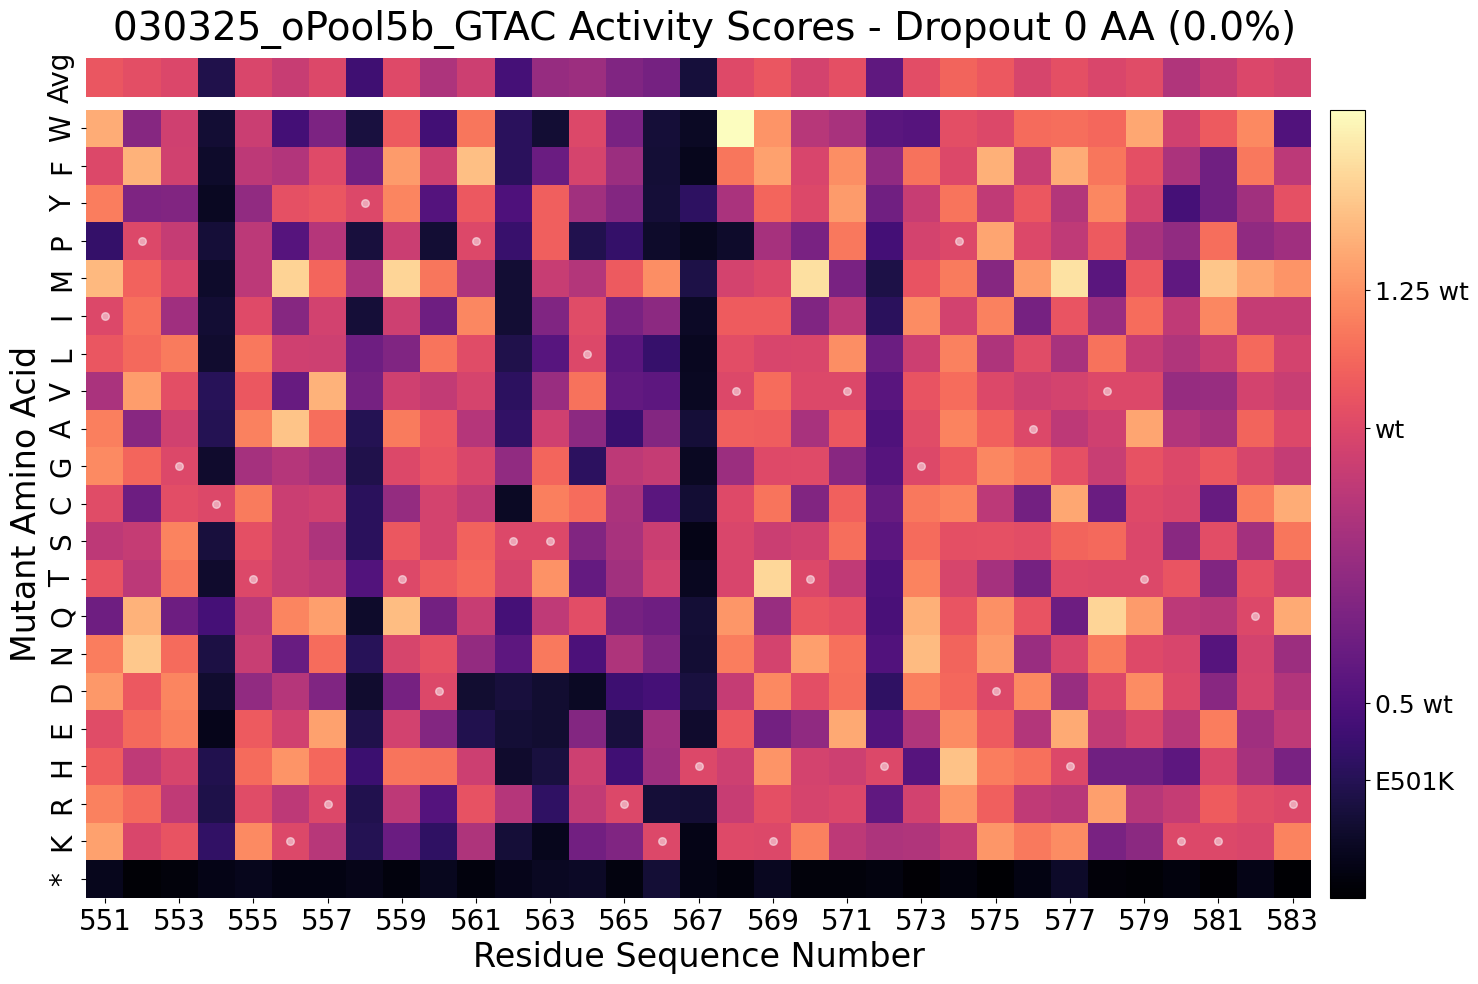

In [272]:
raw_heatmap = dms_heatmap(df, 
                          title=f'{submission} Activity Scores', 
                          min_pos=min_position, 
                          max_pos=max_position, 
                          export=True, 
                          output=f'aa_heatmap_{avg_method}_{export_suffix}.png', 
                          tick_values=colorbar_ticks,
                          tick_labels=colorbar_labels,
                          wt_score=stats['wt_dna_score'],
                          fig_size='small')

In [273]:
# function returns filled heatmap matrix scaffold
df_codon = make_dms_matrix(dfScores_dna, 
                           score_col=score_col, 
                           num_aa=num_aa, 
                           wt_seq=wt_ref_seq, 
                           mutant_type = 'dna')

In [274]:
df_codon

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
W(TGG),1974.775039,1038.598737,1412.299023,423.106078,1382.305519,686.993846,989.645168,464.233884,1603.585697,680.678031,1733.248899,564.912201,423.891187,1487.341381,967.692333,441.190016,361.472484,2344.047055,1866.463069,1281.81852,1214.873788,806.445988,782.877172,1528.256548,1486.225972,1685.602818,1703.416824,1665.108434,1948.069937,1417.850963,1602.782797,1814.939919,757.556872
F(TTT),1510.149605,2145.716207,1398.851294,387.313548,1276.291485,1200.424976,1580.682357,1532.53192,1547.448158,1605.102216,1973.205186,620.174264,579.071191,1123.766826,982.50962,528.138676,340.979983,1782.331494,1753.572255,1530.387991,1437.125988,1454.031123,1803.978455,1378.153694,1977.620499,1369.381766,1422.224934,1588.601523,954.714158,1297.722269,980.637134,1875.163321,1365.55503
F(TTC),1453.975191,1859.172335,1440.027536,382.944609,1360.195724,1318.640272,1427.111168,323.787469,2244.75718,1206.092806,2142.331179,499.219026,1195.923494,1757.296909,1304.171893,330.819619,315.162641,1688.424272,2099.115188,1385.022217,2239.952487,717.873659,1623.477225,1593.9033,2001.681825,1392.723254,2529.664335,1876.016515,2120.154037,1153.603589,853.046368,1608.461527,1260.795488
Y(TAT),1805.566587,1227.016269,923.528295,338.420014,699.321968,1633.157013,1718.373826,1443.78587,1855.886413,216.062835,1414.724804,418.211288,1891.31302,1829.288893,645.220197,393.292968,781.686465,761.739964,1515.429611,1594.96971,1887.689664,663.733042,1627.023495,1691.975166,1333.620956,2143.024145,1272.386484,1313.004248,1523.791893,575.330026,967.301738,673.517214,1705.271028
Y(TAC),1732.172009,755.25549,1101.04973,369.242743,1489.695282,1450.218782,1431.576272,WT,1751.658602,1324.859304,1776.100197,1064.500966,1354.322245,522.779627,1388.191828,491.549512,381.263419,1670.60074,1798.288488,1366.998732,1909.694545,1178.151738,1112.745976,1757.105085,1343.056539,1030.765585,1271.684772,2308.2186,1344.025253,816.780219,874.204251,1679.818811,1387.722903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K(AAA),1988.999997,1047.251961,2058.094466,640.915581,2173.084237,1710.812636,1760.123132,383.5605,831.112467,428.848746,956.904946,377.271381,371.542883,966.4309,1411.086473,2052.101526,281.397556,1348.79069,1195.920889,1791.838645,1399.494261,1343.725729,1568.965995,1295.573125,1742.178992,1556.915734,1663.024398,604.900317,1163.445427,1259.323222,1541.659059,1398.328548,1711.992946
K(AAG),1857.619452,1892.880298,1059.599447,551.921071,1477.89673,WT,806.602114,682.132258,942.525339,746.362916,1536.224459,508.480765,288.608373,893.527561,588.049265,WT,330.406521,1631.104544,WT,1780.380414,1232.544067,1120.185183,933.912044,1409.682701,2001.602284,1947.93711,1998.169567,1337.049016,959.187171,WT,WT,1537.138481,1870.31405
*(TAA),328.844268,195.430288,269.682292,322.974771,298.344814,301.247201,312.098393,252.224762,251.035616,492.955396,270.098068,277.54399,350.817352,564.823217,258.601508,542.841212,339.385667,235.86965,462.053468,259.182037,279.320739,283.416778,200.217745,242.530107,237.402728,346.352498,483.024935,259.846131,247.09157,362.267979,216.477377,347.146376,220.792661
*(TAG),315.621789,259.549539,227.807923,310.975446,394.331985,278.022105,251.234141,249.154746,270.885831,287.201408,293.485073,442.573484,421.017378,282.695044,264.23872,511.51724,255.504535,292.590058,327.265474,226.58071,242.976477,319.039034,241.629585,229.155613,175.251469,317.060988,384.668803,258.130662,275.991691,235.937631,245.284378,275.284487,239.383658


### 64 Codon
DNA sequence activity scores.
Synonymous sequences are not averaged.

Total number of possible variants (19 AA variants, 1 stop codon)*positions + 1 WT): 661
Number of variants that were not observed (total dropout): 3
Percent dropout: 0.5
Min: 111.1723431943767, Max: 2691.6408918625825


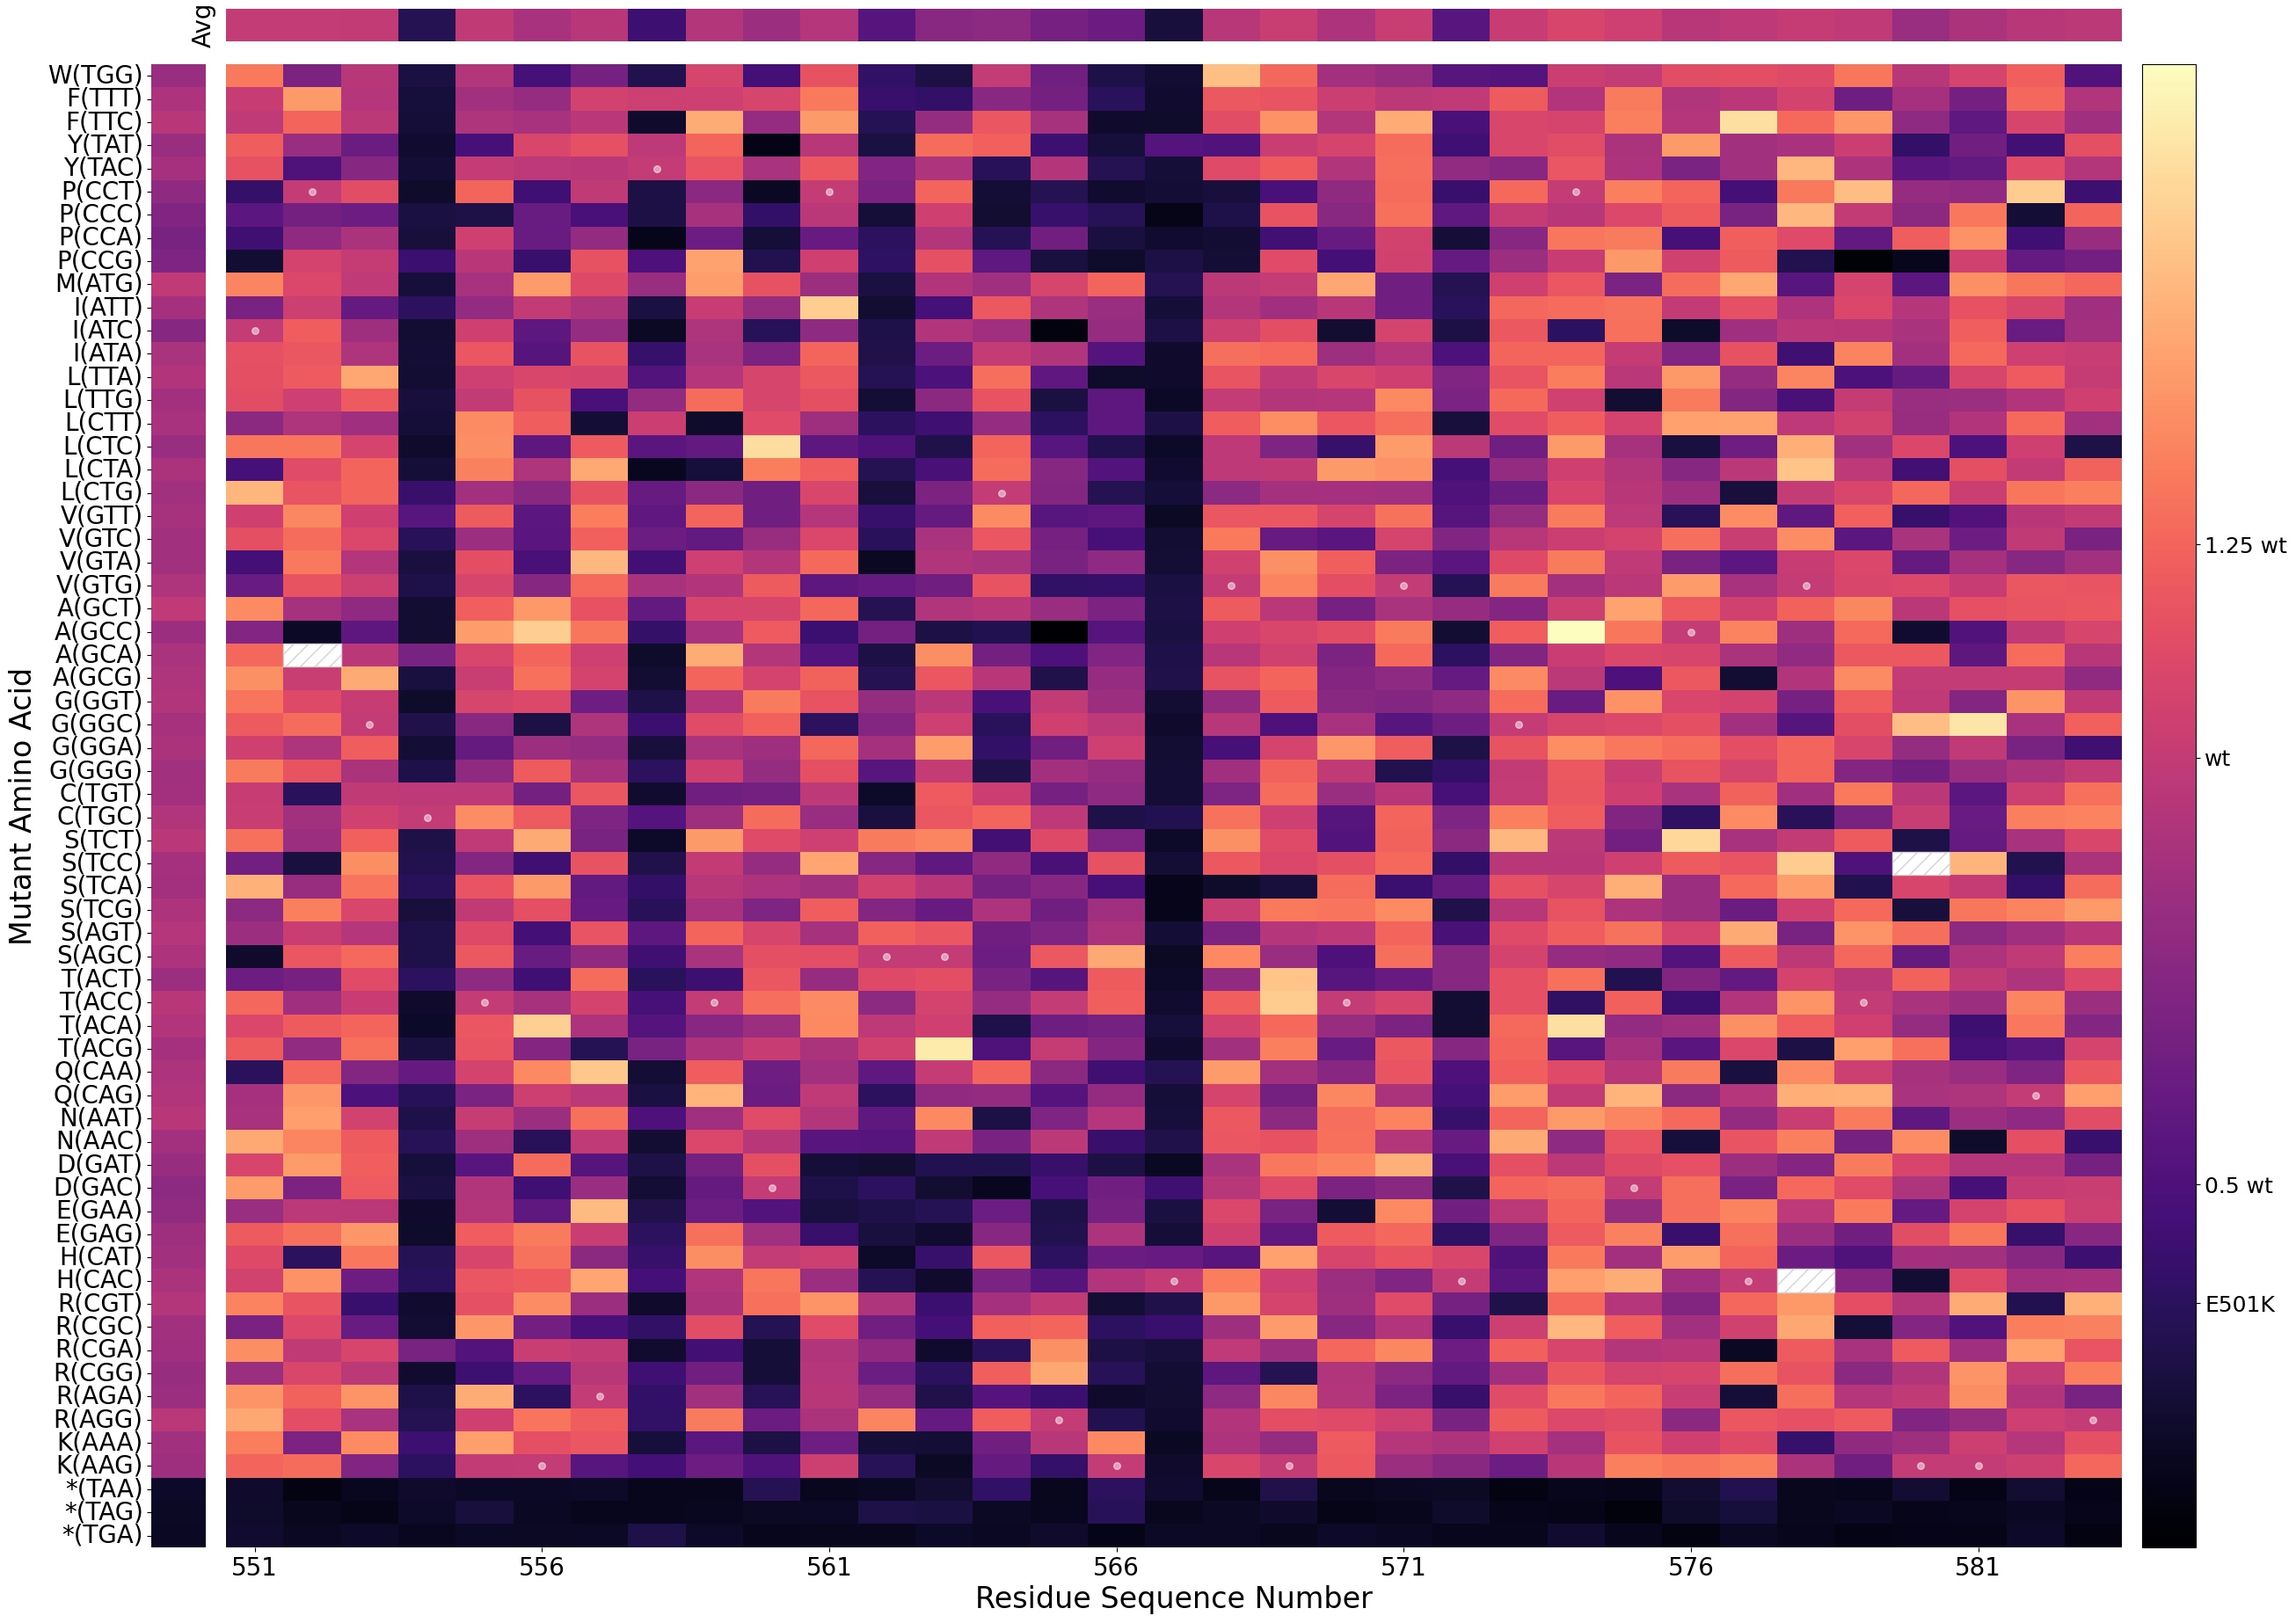

In [275]:
codon_raw_heatmap = dms_heatmap(df_codon, 
                                title=f'{submission} Codon Activity Scores', 
                                min_pos=min_position, 
                                max_pos=max_position, 
                                export=True, 
                                output=f'codon_heatmap_{avg_method}_{export_suffix}.png', 
                                tick_values=colorbar_ticks,
                                tick_labels=colorbar_labels,
                                wt_score=stats['wt_dna_score'],
                                fig_size='long',
                                row_avg=True)
